<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct 18 19:04:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from pytorch_metric_learning import losses
import csv
from torchvision.transforms import v2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=182aa37ae765a31ceccd4f43ab259ed9f84d0cb08c566f3f9fdd4fca76fb226c
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.75G/2.75G [02:10<00:00, 23.2MB/s]
100% 2.75G/2.75G [02:10<00:00, 22.6MB/s]


# Config

In [ ]:
run_name = "convnext-t-cutmix-1"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'p': 0.5,
    'degrees': 10,
    'brightness': 0.1,
    'contrast': 0.1,
    'saturation': 0.1,
    'hue': 0.05,
    'lr':  0.1,
    'factor': 0.1,
    'weight_decay': 0.1,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data",
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data",
    'checkpoint_dir': checkpoint_dir,
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

True


# Dataset

## Dataset Class for doing Image Verification

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [ ]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    torchvision.transforms.RandomHorizontalFlip(p=config['p']),
    torchvision.transforms.RandomRotation(degrees=config['degrees']),
    torchvision.transforms.ColorJitter(brightness=config['brightness'], contrast=config['contrast'], saturation=config['saturation'], hue=config['hue']),
    torchvision.transforms.RandomResizedCrop(size=112, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [ ]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  512
Train batches        :  843
Val batches          :  85


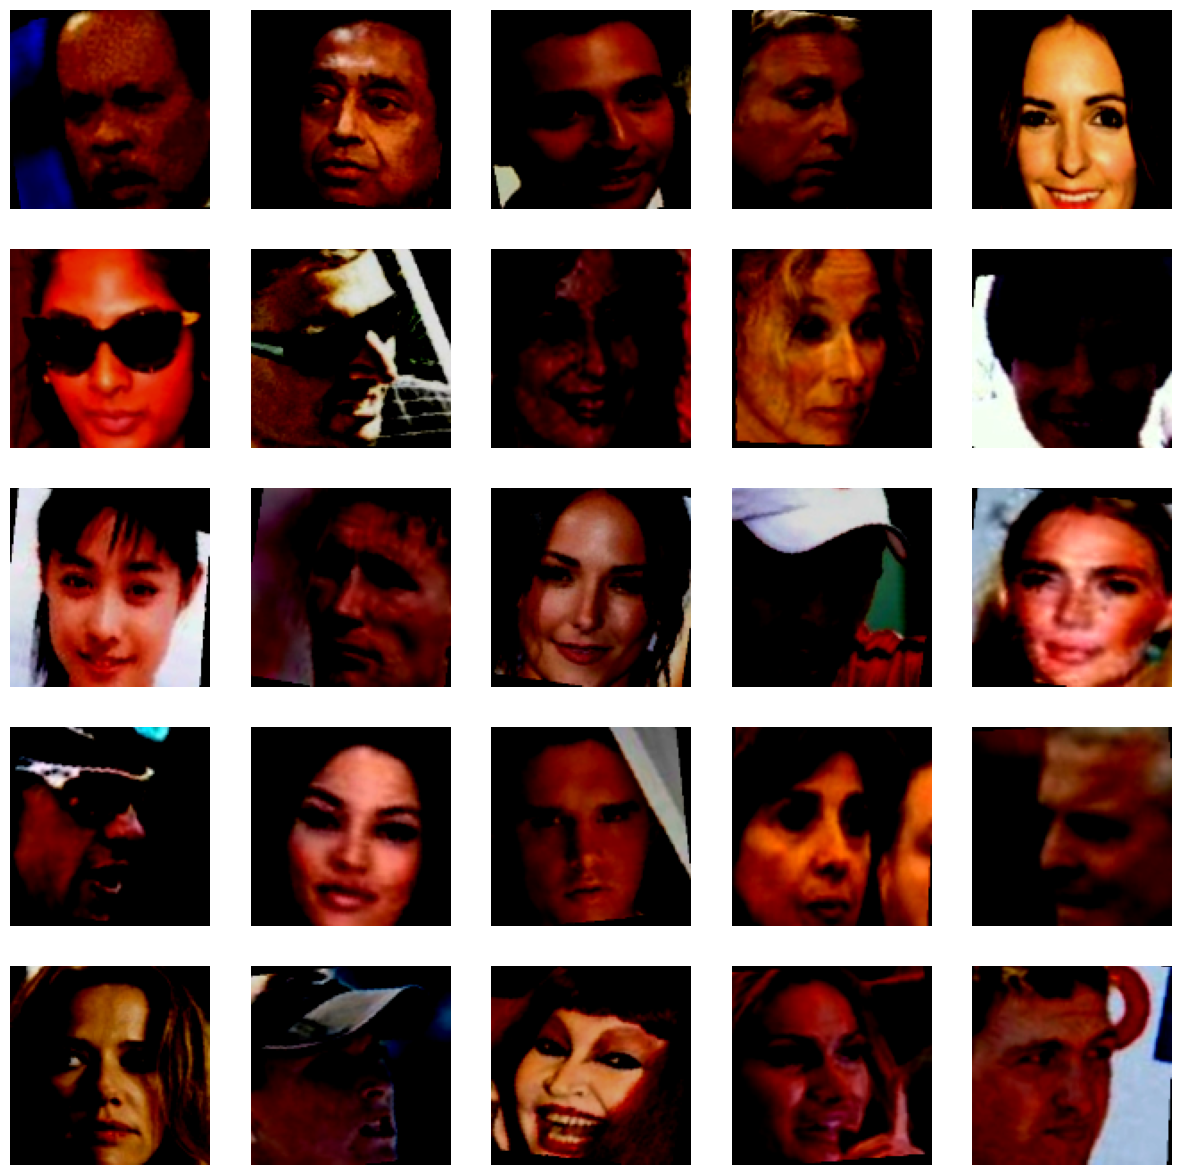

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # Residual Block for ResNet

# class ResidualBlock(torch.nn.Module):
#   expansion = 1

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # Residual Block for ResNet-50

# class ResidualBlock(torch.nn.Module):
#   expansion = 4

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     print(in_channels, out_channels)
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1), torch.nn.BatchNorm2d(out_channels * self.expansion))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer (bottleneck)
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     # Third convolutional layer
#     out = self.conv3(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # ResNet Architecture stacking together blocks
# class ResNet(torch.nn.Module):
#   def __init__(self, block, layers, num_classes=8631):
#     super(ResNet, self).__init__()
#     self.in_channels = 64

#     # Initial convolution and pooling layers
#     self.conv1 = torch.nn.Sequential(
#       torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
#       torch.nn.BatchNorm2d(64),
#       torch.nn.ReLU())
#     self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#     # Residual blocks
#     self.layer1 = self._make_layer(block, 64, layers[0], 1)
#     self.layer2 = self._make_layer(block, 128, layers[1], 2, stride=2)
#     self.layer3 = self._make_layer(block, 256, layers[2], 3, stride=2)
#     self.layer4 = self._make_layer(block, 512, layers[3], 4, stride=2)

#     # Average pooling and fully connected layer
#     self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
#     self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

#   def _make_layer(self, block, out_channels, blocks, i, stride=1):
#     downsample = None
#     if stride != 1 or self.in_channels != out_channels * block.expansion:
#       downsample = torch.nn.Sequential(
#           torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
#                           1, stride=stride),
#           torch.nn.BatchNorm2d(out_channels * block.expansion)
#       )

#     layers = []
#     layers.append(block(self.in_channels, out_channels, stride, downsample))
#     self.in_channels = out_channels * block.expansion
#     for i in range(1, blocks):
#       layers.append(block(self.in_channels, out_channels))

#     return torch.nn.Sequential(*layers)

#   def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         feats = x
#         out = self.fc(x)

#         return {"feats": feats, "out": out}

# model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
# summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Building block for ConvNeXt

class ConvNeXtBlock(nn.Module):
  def __init__(self, dim):
    super(ConvNeXtBlock, self).__init__()

    # Depthwise convolution
    self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

    # Pointwise convolutions
    self.pwconv1 = nn.Linear(dim, 4 * dim)
    self.pwconv2 = nn.Linear(4 * dim, dim)

    # Normalization and activation
    self.ln = nn.LayerNorm(dim, eps=1e-6)
    self.gelu = nn.GELU()

  def forward(self, x):
    input = x

    x = self.dwconv(x)
    x = x.permute(0, 2, 3, 1)
    x = self.ln(x)
    x = self.pwconv1(x)
    x = self.gelu(x)
    x = self.pwconv2(x)
    x = x.permute(0, 3, 1, 2)
    x = x + input

    return x

In [ ]:
# Permute class

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

In [ ]:
# ConvNeXt-T architecture based on 'A ConvNet for the 2020s' (https://arxiv.org/abs/2201.03545)

class ConvNeXt(nn.Module):
  def __init__(self, in_channels=3, num_classes=8631, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
    super(ConvNeXt, self).__init__()

    # Downsampling layers initilization
    self.downsampling_layers = nn.ModuleList()

    # Stem layer
    stem = nn.Sequential(
        nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
        Permute(0, 2, 3, 1),
        nn.LayerNorm(dims[0], eps=1e-6),
        Permute(0, 3, 1, 2),
    )
    self.downsampling_layers.append(stem)

    # Downsampling layers
    for i in range(3):
      downsampling_layer = nn.Sequential(
          Permute(0, 2, 3, 1),
          nn.LayerNorm(dims[i], eps=1e-6),
          Permute(0, 3, 1, 2),
          nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
      )
      self.downsampling_layers.append(downsampling_layer)

    # Stages
    self.stages = nn.ModuleList()
    for i in range(4):
      stage = nn.Sequential(
          *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
      )
      self.stages.append(stage)

    # Final normalization and classification head
    self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
    self.head = nn.Linear(dims[-1], num_classes)

  def forward(self, x):
    for i in range(4):
      # Downsample between stages
      x = self.downsampling_layers[i](x)
      x = self.stages[i](x)
    x = x.mean([-2, -1])
    feats = x
    x = self.norm(x)
    out = self.head(x)

    return {"feats": feats, "out": out}

model = ConvNeXt().to(DEVICE)
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           4,704
           Permute-2           [-1, 28, 28, 96]               0
         LayerNorm-3           [-1, 28, 28, 96]             192
           Permute-4           [-1, 96, 28, 28]               0
            Conv2d-5           [-1, 96, 28, 28]           4,800
         LayerNorm-6           [-1, 28, 28, 96]             192
            Linear-7          [-1, 28, 28, 384]          37,248
              GELU-8          [-1, 28, 28, 384]               0
            Linear-9           [-1, 28, 28, 96]          36,960
    ConvNeXtBlock-10           [-1, 96, 28, 28]               0
           Conv2d-11           [-1, 96, 28, 28]           4,800
        LayerNorm-12           [-1, 28, 28, 96]             192
           Linear-13          [-1, 28, 28, 384]          37,248
             GELU-14          [-1, 28, 

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()
# criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], )
# --------------------------------------------------- #

# Defining Scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=config['factor'], patience=config['patience'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=['T_mult'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], steps_per_epoch=len(train_loader), epochs=config['epochs'], div_factor=10, final_div_factor=1000)
# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-77-94b69f34cee2>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# CutMix

In [ ]:
import torch
import numpy as np

def cutmix_data(images, labels, alpha=1.0):
    """Applies CutMix augmentation to a batch of images and labels"""
    batch_size = images.size(0)
    indices = torch.randperm(batch_size).cuda()

    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)

    # Apply cutmix by replacing a portion of images
    images[:, :, bbx1:bbx2, bby1:bby2] = images[indices, :, bbx1:bbx2, bby1:bby2]

    labels_a = labels
    labels_b = labels[indices]

    return images, labels_a, labels_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly choose center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Calculate box coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
def cutmix_criterion(preds, labels_a, labels_b, lam):
    """Compute the CutMix loss as a weighted sum of the two."""
    return lam * criterion(preds, labels_a) + (1 - lam) * criterion(preds, labels_b)

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):
    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        # send to cuda
        images = images.to(device)
        labels = labels.to(device)

        # Apply CutMix
        if np.random.rand() < config.get('cutmix_prob', 0.5):
            images, labels_a, labels_b, lam = cutmix_data(images, labels)
        else:
            labels_a, labels_b, lam = labels, labels, 1.0

        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = cutmix_criterion(outputs['out'], labels_a, labels_b, lam)

        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update metrics
        loss_m.update(loss.item())
        acc = accuracy(outputs['out'], labels)[0].item()
        acc_m.update(acc)
        lr_scheduler.step()

        batch_bar.set_postfix(acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg), loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg), lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
# def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

#     model.train()

#     # metric meters
#     loss_m = AverageMeter()
#     acc_m = AverageMeter()

#     # Progress Bar
#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

#     for i, (images, labels) in enumerate(dataloader):

#         optimizer.zero_grad() # Zero gradients

#         # send to cuda
#         images = images.to(device, non_blocking=True)
#         if isinstance(labels, (tuple, list)):
#             targets1, targets2, lam = labels
#             labels = (targets1.to(device), targets2.to(device), lam)
#         else:
#             labels = labels.to(device, non_blocking=True)

#         # forward
#         with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
#             outputs = model(images)

#             # Use the type of output depending on the loss function you want to use
#             loss = criterion(outputs['out'], labels)

#         scaler.scale(loss).backward() # This is a replacement for loss.backward()
#         scaler.step(optimizer) # This is a replacement for optimizer.step()
#         scaler.update()
#         # metrics
#         loss_m.update(loss.item())
#         if 'feats' in outputs:
#             acc = accuracy(outputs['out'], labels)[0].item()
#         else:
#             acc = 0.0
#         acc_m.update(acc)

#         # tqdm lets you add some details so you can monitor training as you train.
#         batch_bar.set_postfix(
#             # acc         = "{:.04f}%".format(100*accuracy),
#             acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
#             loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
#             lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

#         batch_bar.update() # Update tqdm bar

#     # You may want to call some schedulers inside the train function. What are these?
#     if lr_scheduler is not None:
#         lr_scheduler.step()

#     batch_bar.close()

#     return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [ ]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = gen_id, ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config, ### Wandb Config for your run
)

# Checkpointing and Loading Model

In [ ]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [ ]:
print(os.path.exists("best_cls.pth"))

False


# Load Pre-Trained Model

In [ ]:
# from pytorch_metric_learning import losses
model, optimizer, scheduler, epoch, metrics = load_model(model, optimizer, scheduler, "best_ret (4).pth")

# optimizer = torch.optim.SGD(model.parameters(), lr=0.09989011473116477)

<ipython-input-29-917ec4f96c61>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: 'best_ret (1).pth'

In [ ]:
criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])
optimizer = torch.optim.SGD(criterion.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config['momentum'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))

# Experiments

In [41]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            # scheduler.step(valid_cls_acc)x

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer,
            'lr': curr_lr
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/100: 
Train Cls. Acc 0.0311%	 Train Cls. Loss 9.0200	 Learning Rate 0.0102


Val Cls. Acc 0.0965%	 Val Cls. Loss 8.6935


{'ACC': 58.1, 'EER': 42.76985743380856, 'AUC': 59.7107462817953, 'TPRs': [('TPR@FPR=1e-4', 1.6293279022403258), ('TPR@FPR=5e-4', 1.6293279022403258), ('TPR@FPR=1e-3', 1.6293279022403258), ('TPR@FPR=5e-3', 3.2586558044806515), ('TPR@FPR=5e-2', 13.238289205702646)]}
Val Ret. Acc 58.1000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 2/100: 
Train Cls. Acc 0.1981%	 Train Cls. Loss 8.6365	 Learning Rate 0.0110


Val Cls. Acc 0.7984%	 Val Cls. Loss 8.0565


{'ACC': 64.5, 'EER': 36.738703339790156, 'AUC': 68.97474781829312, 'TPRs': [('TPR@FPR=1e-4', 2.6476578411405294), ('TPR@FPR=5e-4', 2.6476578411405294), ('TPR@FPR=1e-3', 2.6476578411405294), ('TPR@FPR=5e-3', 5.091649694501019), ('TPR@FPR=5e-2', 17.515274949083505)]}
Val Ret. Acc 64.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 3/100: 
Train Cls. Acc 0.9124%	 Train Cls. Loss 8.1921	 Learning Rate 0.0122


Val Cls. Acc 3.1004%	 Val Cls. Loss 7.4523


{'ACC': 66.7, 'EER': 33.808553971510094, 'AUC': 72.14977652759494, 'TPRs': [('TPR@FPR=1e-4', 2.240325865580448), ('TPR@FPR=5e-4', 2.240325865580448), ('TPR@FPR=1e-3', 2.240325865580448), ('TPR@FPR=5e-3', 7.739307535641547), ('TPR@FPR=5e-2', 26.883910386965375)]}
Val Ret. Acc 66.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 4/100: 
Train Cls. Acc 2.6237%	 Train Cls. Loss 7.8080	 Learning Rate 0.0139


Val Cls. Acc 7.5176%	 Val Cls. Loss 6.8588


{'ACC': 69.8, 'EER': 30.957230142567628, 'AUC': 76.13186672481885, 'TPRs': [('TPR@FPR=1e-4', 3.6659877800407332), ('TPR@FPR=5e-4', 3.6659877800407332), ('TPR@FPR=1e-3', 3.6659877800407332), ('TPR@FPR=5e-3', 8.961303462321792), ('TPR@FPR=5e-2', 32.17922606924644)]}
Val Ret. Acc 69.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 5/100: 
Train Cls. Acc 6.4158%	 Train Cls. Loss 7.3604	 Learning Rate 0.0160


Val Cls. Acc 16.3510%	 Val Cls. Loss 6.1499


{'ACC': 73.0, 'EER': 28.10590631364567, 'AUC': 78.98479107230743, 'TPRs': [('TPR@FPR=1e-4', 10.9979633401222), ('TPR@FPR=5e-4', 10.9979633401222), ('TPR@FPR=1e-3', 10.9979633401222), ('TPR@FPR=5e-3', 11.812627291242363), ('TPR@FPR=5e-2', 36.86354378818738)]}
Val Ret. Acc 73.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 6/100: 
Train Cls. Acc 13.4284%	 Train Cls. Loss 6.7627	 Learning Rate 0.0186


Val Cls. Acc 28.5079%	 Val Cls. Loss 5.3368


{'ACC': 74.6, 'EER': 25.736738703450257, 'AUC': 81.05106054361613, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 36.86354378818738)]}
Val Ret. Acc 74.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 7/100: 
Train Cls. Acc 22.1900%	 Train Cls. Loss 6.2328	 Learning Rate 0.0216


Val Cls. Acc 41.7268%	 Val Cls. Loss 4.5491


{'ACC': 73.9, 'EER': 27.698574338085525, 'AUC': 80.99384200480957, 'TPRs': [('TPR@FPR=1e-4', 15.274949083503056), ('TPR@FPR=5e-4', 15.274949083503056), ('TPR@FPR=1e-3', 15.274949083503056), ('TPR@FPR=5e-3', 24.03258655804481), ('TPR@FPR=5e-2', 46.23217922606925)]}
Val Ret. Acc 73.9000%
Saved epoch model
Saved best classification model

Epoch 8/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 8/100: 
Train Cls. Acc 33.3087%	 Train Cls. Loss 5.5984	 Learning Rate 0.0249


Val Cls. Acc 53.4023%	 Val Cls. Loss 3.9553


{'ACC': 77.3, 'EER': 23.379174852632488, 'AUC': 84.39374357291763, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 28.716904276985744), ('TPR@FPR=5e-2', 50.509164969450104)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 9/100: 
Train Cls. Acc 41.6285%	 Train Cls. Loss 5.1007	 Learning Rate 0.0286


Val Cls. Acc 64.8905%	 Val Cls. Loss 3.3150


{'ACC': 76.9, 'EER': 23.82892057026477, 'AUC': 84.83548669769006, 'TPRs': [('TPR@FPR=1e-4', 29.531568228105908), ('TPR@FPR=5e-4', 29.531568228105908), ('TPR@FPR=1e-3', 29.531568228105908), ('TPR@FPR=5e-3', 30.95723014256619), ('TPR@FPR=5e-2', 51.73116089613035)]}
Val Ret. Acc 76.9000%
Saved epoch model
Saved best classification model

Epoch 10/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 10/100: 
Train Cls. Acc 47.5595%	 Train Cls. Loss 4.7738	 Learning Rate 0.0325


Val Cls. Acc 70.4990%	 Val Cls. Loss 3.0388


{'ACC': 75.9, 'EER': 25.66191446028509, 'AUC': 83.27097979745439, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 26.069246435845212), ('TPR@FPR=5e-2', 50.30549898167006)]}
Val Ret. Acc 75.9000%
Saved epoch model
Saved best classification model

Epoch 11/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 11/100: 
Train Cls. Acc 52.2318%	 Train Cls. Loss 4.5340	 Learning Rate 0.0367


Val Cls. Acc 74.9016%	 Val Cls. Loss 2.8107


{'ACC': 77.1, 'EER': 24.032586558044834, 'AUC': 84.8803012175945, 'TPRs': [('TPR@FPR=1e-4', 18.94093686354379), ('TPR@FPR=5e-4', 18.94093686354379), ('TPR@FPR=1e-3', 18.94093686354379), ('TPR@FPR=5e-3', 26.476578411405292), ('TPR@FPR=5e-2', 46.435845213849284)]}
Val Ret. Acc 77.1000%
Saved epoch model
Saved best classification model

Epoch 12/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 12/100: 
Train Cls. Acc 56.6209%	 Train Cls. Loss 4.2004	 Learning Rate 0.0411


Val Cls. Acc 77.2223%	 Val Cls. Loss 2.6546


{'ACC': 79.4, 'EER': 22.00392927317448, 'AUC': 85.41367403038585, 'TPRs': [('TPR@FPR=1e-4', 14.25661914460285), ('TPR@FPR=5e-4', 14.25661914460285), ('TPR@FPR=1e-3', 14.25661914460285), ('TPR@FPR=5e-3', 24.236252545824847), ('TPR@FPR=5e-2', 53.76782077393075)]}
Val Ret. Acc 79.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 13/100: 
Train Cls. Acc 59.3117%	 Train Cls. Loss 4.0419	 Learning Rate 0.0456


Val Cls. Acc 80.0851%	 Val Cls. Loss 2.5358


{'ACC': 78.7, 'EER': 22.403258655804475, 'AUC': 85.00754244375179, 'TPRs': [('TPR@FPR=1e-4', 11.608961303462321), ('TPR@FPR=5e-4', 11.608961303462321), ('TPR@FPR=1e-3', 11.608961303462321), ('TPR@FPR=5e-3', 32.17922606924644), ('TPR@FPR=5e-2', 53.56415478615071)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best classification model

Epoch 14/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 14/100: 
Train Cls. Acc 63.0635%	 Train Cls. Loss 3.9677	 Learning Rate 0.0503


Val Cls. Acc 81.3844%	 Val Cls. Loss 2.4542


{'ACC': 79.9, 'EER': 20.235756385073667, 'AUC': 86.86494424193438, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 22.606924643584524), ('TPR@FPR=5e-2', 57.23014256619145)]}
Val Ret. Acc 79.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 15/100: 
Train Cls. Acc 63.8576%	 Train Cls. Loss 3.7939	 Learning Rate 0.0550


Val Cls. Acc 83.1445%	 Val Cls. Loss 2.3848


{'ACC': 78.7, 'EER': 22.00392927300839, 'AUC': 86.56084571401134, 'TPRs': [('TPR@FPR=1e-4', 12.219959266802444), ('TPR@FPR=5e-4', 12.219959266802444), ('TPR@FPR=1e-3', 12.219959266802444), ('TPR@FPR=5e-3', 25.45824847250509), ('TPR@FPR=5e-2', 55.397148676171085)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best classification model

Epoch 16/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 16/100: 
Train Cls. Acc 65.2925%	 Train Cls. Loss 3.6729	 Learning Rate 0.0597


Val Cls. Acc 82.8973%	 Val Cls. Loss 2.3593


{'ACC': 78.8, 'EER': 21.8074656187258, 'AUC': 86.50362717520477, 'TPRs': [('TPR@FPR=1e-4', 16.700610997963338), ('TPR@FPR=5e-4', 16.700610997963338), ('TPR@FPR=1e-3', 16.700610997963338), ('TPR@FPR=5e-3', 35.234215885947044), ('TPR@FPR=5e-2', 58.65580448065173)]}
Val Ret. Acc 78.8000%
Saved epoch model

Epoch 17/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 17/100: 
Train Cls. Acc 67.5959%	 Train Cls. Loss 3.5998	 Learning Rate 0.0644


Val Cls. Acc 84.8205%	 Val Cls. Loss 2.2687


{'ACC': 79.0, 'EER': 21.38492871690306, 'AUC': 86.03147419764004, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 32.79022403258656), ('TPR@FPR=5e-2', 55.397148676171085)]}
Val Ret. Acc 79.0000%
Saved epoch model
Saved best classification model

Epoch 18/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 18/100: 
Train Cls. Acc 68.7959%	 Train Cls. Loss 3.5133	 Learning Rate 0.0689


Val Cls. Acc 85.2317%	 Val Cls. Loss 2.2302


{'ACC': 80.5, 'EER': 19.755600814664017, 'AUC': 87.41512249968989, 'TPRs': [('TPR@FPR=1e-4', 14.867617107942973), ('TPR@FPR=5e-4', 14.867617107942973), ('TPR@FPR=1e-3', 14.867617107942973), ('TPR@FPR=5e-3', 29.531568228105908), ('TPR@FPR=5e-2', 59.877800407331975)]}
Val Ret. Acc 80.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 19/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 19/100: 
Train Cls. Acc 67.4570%	 Train Cls. Loss 3.5692	 Learning Rate 0.0733


Val Cls. Acc 85.2696%	 Val Cls. Loss 2.2415


{'ACC': 79.9, 'EER': 20.36659877800408, 'AUC': 87.51235400269688, 'TPRs': [('TPR@FPR=1e-4', 13.64562118126273), ('TPR@FPR=5e-4', 13.64562118126273), ('TPR@FPR=1e-3', 13.64562118126273), ('TPR@FPR=5e-3', 35.234215885947044), ('TPR@FPR=5e-2', 58.248472505091655)]}
Val Ret. Acc 79.9000%
Saved epoch model
Saved best classification model

Epoch 20/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 20/100: 
Train Cls. Acc 70.2112%	 Train Cls. Loss 3.4011	 Learning Rate 0.0775


Val Cls. Acc 86.0555%	 Val Cls. Loss 2.2242


{'ACC': 80.5, 'EER': 20.628683693526924, 'AUC': 87.83005693844807, 'TPRs': [('TPR@FPR=1e-4', 20.773930753564155), ('TPR@FPR=5e-4', 20.773930753564155), ('TPR@FPR=1e-3', 20.773930753564155), ('TPR@FPR=5e-3', 33.19755600814664), ('TPR@FPR=5e-2', 61.30346232179226)]}
Val Ret. Acc 80.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 21/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 21/100: 
Train Cls. Acc 70.6969%	 Train Cls. Loss 3.3070	 Learning Rate 0.0815


Val Cls. Acc 85.4019%	 Val Cls. Loss 2.2288


{'ACC': 81.2, 'EER': 19.253438114062185, 'AUC': 88.37343299228951, 'TPRs': [('TPR@FPR=1e-4', 19.75560081466395), ('TPR@FPR=5e-4', 19.75560081466395), ('TPR@FPR=1e-3', 19.75560081466395), ('TPR@FPR=5e-3', 27.90224032586558), ('TPR@FPR=5e-2', 61.710794297352344)]}
Val Ret. Acc 81.2000%
Saved epoch model
Saved best retrieval model

Epoch 22/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 22/100: 
Train Cls. Acc 70.6888%	 Train Cls. Loss 3.3154	 Learning Rate 0.0851


Val Cls. Acc 86.7254%	 Val Cls. Loss 2.1803


{'ACC': 80.9, 'EER': 20.039292730878362, 'AUC': 88.11094794713486, 'TPRs': [('TPR@FPR=1e-4', 22.403258655804482), ('TPR@FPR=5e-4', 22.403258655804482), ('TPR@FPR=1e-3', 22.403258655804482), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 64.15478615071282)]}
Val Ret. Acc 80.9000%
Saved epoch model
Saved best classification model

Epoch 23/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 23/100: 
Train Cls. Acc 71.9399%	 Train Cls. Loss 3.1710	 Learning Rate 0.0884


Val Cls. Acc 87.4284%	 Val Cls. Loss 2.1585


{'ACC': 81.9, 'EER': 18.66404715133723, 'AUC': 88.88879997119068, 'TPRs': [('TPR@FPR=1e-4', 15.682281059063136), ('TPR@FPR=5e-4', 15.682281059063136), ('TPR@FPR=1e-3', 15.682281059063136), ('TPR@FPR=5e-3', 36.65987780040733), ('TPR@FPR=5e-2', 62.93279022403259)]}
Val Ret. Acc 81.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 24/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 24/100: 
Train Cls. Acc 70.3867%	 Train Cls. Loss 3.2552	 Learning Rate 0.0914


Val Cls. Acc 86.3370%	 Val Cls. Loss 2.1783


{'ACC': 81.2, 'EER': 20.570264765751908, 'AUC': 88.59750559181174, 'TPRs': [('TPR@FPR=1e-4', 14.867617107942973), ('TPR@FPR=5e-4', 14.867617107942973), ('TPR@FPR=1e-3', 14.867617107942973), ('TPR@FPR=5e-3', 28.5132382892057), ('TPR@FPR=5e-2', 61.91446028513238)]}
Val Ret. Acc 81.2000%
Saved epoch model

Epoch 25/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 25/100: 
Train Cls. Acc 71.5007%	 Train Cls. Loss 3.1360	 Learning Rate 0.0940


Val Cls. Acc 86.8573%	 Val Cls. Loss 2.1660


{'ACC': 82.2, 'EER': 19.348268839103866, 'AUC': 88.52588238589303, 'TPRs': [('TPR@FPR=1e-4', 19.75560081466395), ('TPR@FPR=5e-4', 19.75560081466395), ('TPR@FPR=1e-3', 19.75560081466395), ('TPR@FPR=5e-3', 32.9938900203666), ('TPR@FPR=5e-2', 60.692464358452135)]}
Val Ret. Acc 82.2000%
Saved epoch model
Saved best retrieval model

Epoch 26/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 26/100: 
Train Cls. Acc 73.7991%	 Train Cls. Loss 3.1702	 Learning Rate 0.0961


Val Cls. Acc 87.9740%	 Val Cls. Loss 2.1421


{'ACC': 82.2, 'EER': 19.449901768241027, 'AUC': 88.92681228718105, 'TPRs': [('TPR@FPR=1e-4', 25.45824847250509), ('TPR@FPR=5e-4', 25.45824847250509), ('TPR@FPR=1e-3', 25.45824847250509), ('TPR@FPR=5e-3', 33.19755600814664), ('TPR@FPR=5e-2', 68.83910386965377)]}
Val Ret. Acc 82.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 27/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 27/100: 
Train Cls. Acc 72.3058%	 Train Cls. Loss 3.1463	 Learning Rate 0.0978


Val Cls. Acc 88.2717%	 Val Cls. Loss 2.1033


{'ACC': 82.4, 'EER': 18.53360488798369, 'AUC': 88.70594072479483, 'TPRs': [('TPR@FPR=1e-4', 18.533604887983707), ('TPR@FPR=5e-4', 18.533604887983707), ('TPR@FPR=1e-3', 18.533604887983707), ('TPR@FPR=5e-3', 37.06720977596741), ('TPR@FPR=5e-2', 66.19144602851324)]}
Val Ret. Acc 82.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 28/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 28/100: 
Train Cls. Acc 73.7158%	 Train Cls. Loss 3.0034	 Learning Rate 0.0990


Val Cls. Acc 88.5048%	 Val Cls. Loss 2.0936


{'ACC': 83.3, 'EER': 18.737270875763492, 'AUC': 89.6494464206403, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 35.437881873727086), ('TPR@FPR=5e-2', 67.82077393075356)]}
Val Ret. Acc 83.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 29/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 29/100: 
Train Cls. Acc 71.6821%	 Train Cls. Loss 3.0852	 Learning Rate 0.0998


Val Cls. Acc 87.8662%	 Val Cls. Loss 2.1016


{'ACC': 82.8, 'EER': 18.737270875768257, 'AUC': 89.15368579419732, 'TPRs': [('TPR@FPR=1e-4', 26.680244399185337), ('TPR@FPR=5e-4', 26.680244399185337), ('TPR@FPR=1e-3', 26.680244399185337), ('TPR@FPR=5e-3', 39.5112016293279), ('TPR@FPR=5e-2', 63.543788187372705)]}
Val Ret. Acc 82.8000%
Saved epoch model

Epoch 30/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 30/100: 
Train Cls. Acc 73.9041%	 Train Cls. Loss 2.9946	 Learning Rate 0.1000


Val Cls. Acc 88.1843%	 Val Cls. Loss 2.1027


{'ACC': 84.1, 'EER': 18.737270875763148, 'AUC': 89.43737771037816, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 39.91853360488798), ('TPR@FPR=5e-2', 63.34012219959266)]}
Val Ret. Acc 84.1000%
Saved epoch model
Saved best retrieval model

Epoch 31/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 31/100: 
Train Cls. Acc 71.6977%	 Train Cls. Loss 3.0640	 Learning Rate 0.0999


Val Cls. Acc 88.1890%	 Val Cls. Loss 2.1096


{'ACC': 83.6, 'EER': 17.485265225901042, 'AUC': 89.70626482980487, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 37.67820773930753), ('TPR@FPR=5e-2', 66.80244399185335)]}
Val Ret. Acc 83.6000%
Saved epoch model

Epoch 32/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 32/100: 
Train Cls. Acc 71.8829%	 Train Cls. Loss 3.0734	 Learning Rate 0.0998


Val Cls. Acc 88.7702%	 Val Cls. Loss 2.1023


{'ACC': 81.9, 'EER': 19.0569744597099, 'AUC': 89.23011055582009, 'TPRs': [('TPR@FPR=1e-4', 27.494908350305497), ('TPR@FPR=5e-4', 27.494908350305497), ('TPR@FPR=1e-3', 27.494908350305497), ('TPR@FPR=5e-3', 39.71486761710794), ('TPR@FPR=5e-2', 62.11812627291242)]}
Val Ret. Acc 81.9000%
Saved epoch model
Saved best classification model

Epoch 33/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 33/100: 
Train Cls. Acc 74.1601%	 Train Cls. Loss 2.8612	 Learning Rate 0.0995


Val Cls. Acc 88.7551%	 Val Cls. Loss 2.0874


{'ACC': 83.9, 'EER': 17.09233791738124, 'AUC': 90.17201573309754, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 35.437881873727086), ('TPR@FPR=5e-2', 67.0061099796334)]}
Val Ret. Acc 83.9000%
Saved epoch model

Epoch 34/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 34/100: 
Train Cls. Acc 75.2435%	 Train Cls. Loss 2.8712	 Learning Rate 0.0992


Val Cls. Acc 89.3423%	 Val Cls. Loss 2.0342


{'ACC': 83.0, 'EER': 18.73727087576374, 'AUC': 89.86111500126042, 'TPRs': [('TPR@FPR=1e-4', 30.346232179226067), ('TPR@FPR=5e-4', 30.346232179226067), ('TPR@FPR=1e-3', 30.346232179226067), ('TPR@FPR=5e-3', 49.287169042769854), ('TPR@FPR=5e-2', 64.56211812627292)]}
Val Ret. Acc 83.0000%
Saved epoch model
Saved best classification model

Epoch 35/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 35/100: 
Train Cls. Acc 73.7934%	 Train Cls. Loss 2.8559	 Learning Rate 0.0987


Val Cls. Acc 86.9112%	 Val Cls. Loss 2.2491


{'ACC': 83.6, 'EER': 17.515274949083874, 'AUC': 89.66465134703643, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 38.69653767820774), ('TPR@FPR=5e-2', 65.78411405295316)]}
Val Ret. Acc 83.6000%
Saved epoch model

Epoch 36/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 36/100: 
Train Cls. Acc 72.9664%	 Train Cls. Loss 2.8677	 Learning Rate 0.0982


Val Cls. Acc 88.6174%	 Val Cls. Loss 2.1021


{'ACC': 83.0, 'EER': 18.73727087576374, 'AUC': 89.43897822894617, 'TPRs': [('TPR@FPR=1e-4', 24.43991853360489), ('TPR@FPR=5e-4', 24.43991853360489), ('TPR@FPR=1e-3', 24.43991853360489), ('TPR@FPR=5e-3', 38.085539714867615), ('TPR@FPR=5e-2', 66.19144602851324)]}
Val Ret. Acc 83.0000%
Saved epoch model

Epoch 37/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 37/100: 
Train Cls. Acc 73.0060%	 Train Cls. Loss 2.8292	 Learning Rate 0.0976


Val Cls. Acc 88.8311%	 Val Cls. Loss 2.1003


{'ACC': 83.5, 'EER': 17.922606924643585, 'AUC': 89.53220843553311, 'TPRs': [('TPR@FPR=1e-4', 27.08757637474542), ('TPR@FPR=5e-4', 27.08757637474542), ('TPR@FPR=1e-3', 27.08757637474542), ('TPR@FPR=5e-3', 33.401221995926676), ('TPR@FPR=5e-2', 64.15478615071282)]}
Val Ret. Acc 83.5000%
Saved epoch model

Epoch 38/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 38/100: 
Train Cls. Acc 74.3593%	 Train Cls. Loss 2.8086	 Learning Rate 0.0968


Val Cls. Acc 89.4044%	 Val Cls. Loss 2.0283


{'ACC': 83.7, 'EER': 17.71894093686356, 'AUC': 90.44090285252422, 'TPRs': [('TPR@FPR=1e-4', 31.975560081466398), ('TPR@FPR=5e-4', 31.975560081466398), ('TPR@FPR=1e-3', 31.975560081466398), ('TPR@FPR=5e-3', 47.04684317718941), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 83.7000%
Saved epoch model
Saved best classification model

Epoch 39/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 39/100: 
Train Cls. Acc 75.0641%	 Train Cls. Loss 2.8383	 Learning Rate 0.0960


Val Cls. Acc 89.7709%	 Val Cls. Loss 2.0485


{'ACC': 82.1, 'EER': 19.348268839103866, 'AUC': 88.97122667744351, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 36.86354378818738), ('TPR@FPR=5e-2', 63.951120162932796)]}
Val Ret. Acc 82.1000%
Saved epoch model
Saved best classification model

Epoch 40/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 40/100: 
Train Cls. Acc 75.9024%	 Train Cls. Loss 2.7413	 Learning Rate 0.0950


Val Cls. Acc 89.5617%	 Val Cls. Loss 2.0359


{'ACC': 82.4, 'EER': 18.467583496973766, 'AUC': 89.47018834102249, 'TPRs': [('TPR@FPR=1e-4', 38.4928716904277), ('TPR@FPR=5e-4', 38.4928716904277), ('TPR@FPR=1e-3', 38.4928716904277), ('TPR@FPR=5e-3', 41.955193482688394), ('TPR@FPR=5e-2', 65.58044806517312)]}
Val Ret. Acc 82.4000%
Saved epoch model

Epoch 41/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 41/100: 
Train Cls. Acc 73.4081%	 Train Cls. Loss 2.8174	 Learning Rate 0.0940


Val Cls. Acc 89.2253%	 Val Cls. Loss 2.0674


{'ACC': 81.9, 'EER': 19.0569744596332, 'AUC': 89.36535437481744, 'TPRs': [('TPR@FPR=1e-4', 36.86354378818738), ('TPR@FPR=5e-4', 36.86354378818738), ('TPR@FPR=1e-3', 36.86354378818738), ('TPR@FPR=5e-3', 38.90020366598778), ('TPR@FPR=5e-2', 65.37678207739307)]}
Val Ret. Acc 81.9000%
Saved epoch model

Epoch 42/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 42/100: 
Train Cls. Acc 73.8307%	 Train Cls. Loss 2.7531	 Learning Rate 0.0929


Val Cls. Acc 89.6145%	 Val Cls. Loss 2.0183


{'ACC': 83.3, 'EER': 18.5336048879837, 'AUC': 89.24971690827829, 'TPRs': [('TPR@FPR=1e-4', 37.06720977596741), ('TPR@FPR=5e-4', 37.06720977596741), ('TPR@FPR=1e-3', 37.06720977596741), ('TPR@FPR=5e-3', 39.91853360488798), ('TPR@FPR=5e-2', 64.35845213849288)]}
Val Ret. Acc 83.3000%
Saved epoch model

Epoch 43/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 43/100: 
Train Cls. Acc 74.4373%	 Train Cls. Loss 2.7447	 Learning Rate 0.0917


Val Cls. Acc 89.2698%	 Val Cls. Loss 2.1140


{'ACC': 83.5, 'EER': 17.922606924637922, 'AUC': 90.11719797214298, 'TPRs': [('TPR@FPR=1e-4', 32.9938900203666), ('TPR@FPR=5e-4', 32.9938900203666), ('TPR@FPR=1e-3', 32.9938900203666), ('TPR@FPR=5e-3', 41.34419551934827), ('TPR@FPR=5e-2', 66.80244399185335)]}
Val Ret. Acc 83.5000%
Saved epoch model

Epoch 44/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 44/100: 
Train Cls. Acc 74.5888%	 Train Cls. Loss 2.6968	 Learning Rate 0.0905


Val Cls. Acc 89.8007%	 Val Cls. Loss 2.0566


{'ACC': 83.0, 'EER': 19.348268839103806, 'AUC': 89.30733557672687, 'TPRs': [('TPR@FPR=1e-4', 26.069246435845212), ('TPR@FPR=5e-4', 26.069246435845212), ('TPR@FPR=1e-3', 26.069246435845212), ('TPR@FPR=5e-3', 34.82688391038696), ('TPR@FPR=5e-2', 65.9877800407332)]}
Val Ret. Acc 83.0000%
Saved epoch model
Saved best classification model

Epoch 45/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 45/100: 
Train Cls. Acc 75.0511%	 Train Cls. Loss 2.7086	 Learning Rate 0.0891


Val Cls. Acc 90.3613%	 Val Cls. Loss 2.0267


{'ACC': 83.2, 'EER': 18.329938900205335, 'AUC': 89.70666495944685, 'TPRs': [('TPR@FPR=1e-4', 27.494908350305497), ('TPR@FPR=5e-4', 27.494908350305497), ('TPR@FPR=1e-3', 27.494908350305497), ('TPR@FPR=5e-3', 37.06720977596741), ('TPR@FPR=5e-2', 64.35845213849288)]}
Val Ret. Acc 83.2000%
Saved epoch model
Saved best classification model

Epoch 46/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 46/100: 
Train Cls. Acc 74.4419%	 Train Cls. Loss 2.7030	 Learning Rate 0.0877


Val Cls. Acc 90.4188%	 Val Cls. Loss 2.0292


{'ACC': 82.6, 'EER': 17.922606924643574, 'AUC': 89.72066949691701, 'TPRs': [('TPR@FPR=1e-4', 31.160896130346234), ('TPR@FPR=5e-4', 31.160896130346234), ('TPR@FPR=1e-3', 31.160896130346234), ('TPR@FPR=5e-3', 33.604887983706725), ('TPR@FPR=5e-2', 63.951120162932796)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best classification model

Epoch 47/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 47/100: 
Train Cls. Acc 76.0732%	 Train Cls. Loss 2.6284	 Learning Rate 0.0861


Val Cls. Acc 88.9001%	 Val Cls. Loss 2.1112


{'ACC': 80.8, 'EER': 20.432220039329728, 'AUC': 87.9348909046531, 'TPRs': [('TPR@FPR=1e-4', 25.050916496945007), ('TPR@FPR=5e-4', 25.050916496945007), ('TPR@FPR=1e-3', 25.050916496945007), ('TPR@FPR=5e-3', 34.0122199592668), ('TPR@FPR=5e-2', 60.896130346232184)]}
Val Ret. Acc 80.8000%
Saved epoch model

Epoch 48/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 48/100: 
Train Cls. Acc 74.6407%	 Train Cls. Loss 2.6390	 Learning Rate 0.0846


Val Cls. Acc 90.2086%	 Val Cls. Loss 2.0946


{'ACC': 82.1, 'EER': 19.551934826930705, 'AUC': 88.75275589290929, 'TPRs': [('TPR@FPR=1e-4', 16.293279022403258), ('TPR@FPR=5e-4', 16.293279022403258), ('TPR@FPR=1e-3', 16.293279022403258), ('TPR@FPR=5e-3', 32.586558044806516), ('TPR@FPR=5e-2', 66.39511201629328)]}
Val Ret. Acc 82.1000%
Saved epoch model

Epoch 49/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 49/100: 
Train Cls. Acc 76.8009%	 Train Cls. Loss 2.5856	 Learning Rate 0.0829


Val Cls. Acc 88.5243%	 Val Cls. Loss 2.1113


{'ACC': 83.1, 'EER': 18.46758349705535, 'AUC': 89.60743280822987, 'TPRs': [('TPR@FPR=1e-4', 28.105906313645622), ('TPR@FPR=5e-4', 28.105906313645622), ('TPR@FPR=1e-3', 28.105906313645622), ('TPR@FPR=5e-3', 40.936863543788185), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 83.1000%
Saved epoch model

Epoch 50/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 50/100: 
Train Cls. Acc 74.7892%	 Train Cls. Loss 2.5454	 Learning Rate 0.0812


Val Cls. Acc 90.5084%	 Val Cls. Loss 2.0363


{'ACC': 82.1, 'EER': 18.533604887983696, 'AUC': 89.52380571305103, 'TPRs': [('TPR@FPR=1e-4', 35.64154786150713), ('TPR@FPR=5e-4', 35.64154786150713), ('TPR@FPR=1e-3', 35.64154786150713), ('TPR@FPR=5e-3', 44.19551934826884), ('TPR@FPR=5e-2', 66.59877800407332)]}
Val Ret. Acc 82.1000%
Saved epoch model
Saved best classification model

Epoch 51/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 51/100: 
Train Cls. Acc 75.7558%	 Train Cls. Loss 2.5819	 Learning Rate 0.0794


Val Cls. Acc 90.6774%	 Val Cls. Loss 2.0307


{'ACC': 82.5, 'EER': 18.533604887983703, 'AUC': 89.19770005481776, 'TPRs': [('TPR@FPR=1e-4', 30.75356415478615), ('TPR@FPR=5e-4', 30.75356415478615), ('TPR@FPR=1e-3', 30.75356415478615), ('TPR@FPR=5e-3', 37.06720977596741), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 82.5000%
Saved epoch model
Saved best classification model

Epoch 52/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 52/100: 
Train Cls. Acc 75.0459%	 Train Cls. Loss 2.5725	 Learning Rate 0.0775


Val Cls. Acc 90.7152%	 Val Cls. Loss 2.0057


{'ACC': 83.3, 'EER': 17.922606924645088, 'AUC': 89.98835622741768, 'TPRs': [('TPR@FPR=1e-4', 38.90020366598778), ('TPR@FPR=5e-4', 38.90020366598778), ('TPR@FPR=1e-3', 38.90020366598778), ('TPR@FPR=5e-3', 45.41751527494908), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 83.3000%
Saved epoch model
Saved best classification model

Epoch 53/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 53/100: 
Train Cls. Acc 75.0702%	 Train Cls. Loss 2.6348	 Learning Rate 0.0756


Val Cls. Acc 91.1231%	 Val Cls. Loss 2.0630


{'ACC': 82.5, 'EER': 18.5336048879837, 'AUC': 89.24571561185824, 'TPRs': [('TPR@FPR=1e-4', 30.95723014256619), ('TPR@FPR=5e-4', 30.95723014256619), ('TPR@FPR=1e-3', 30.95723014256619), ('TPR@FPR=5e-3', 36.86354378818738), ('TPR@FPR=5e-2', 66.39511201629328)]}
Val Ret. Acc 82.5000%
Saved epoch model
Saved best classification model

Epoch 54/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 54/100: 
Train Cls. Acc 75.4589%	 Train Cls. Loss 2.6032	 Learning Rate 0.0737


Val Cls. Acc 89.9983%	 Val Cls. Loss 2.0629


{'ACC': 83.7, 'EER': 18.73727087576408, 'AUC': 89.17649318379156, 'TPRs': [('TPR@FPR=1e-4', 26.069246435845212), ('TPR@FPR=5e-4', 26.069246435845212), ('TPR@FPR=1e-3', 26.069246435845212), ('TPR@FPR=5e-3', 44.19551934826884), ('TPR@FPR=5e-2', 67.61710794297352)]}
Val Ret. Acc 83.7000%
Saved epoch model

Epoch 55/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 55/100: 
Train Cls. Acc 76.8356%	 Train Cls. Loss 2.4669	 Learning Rate 0.0717


Val Cls. Acc 90.9646%	 Val Cls. Loss 2.0219


{'ACC': 83.4, 'EER': 17.922606924643585, 'AUC': 89.75828168326538, 'TPRs': [('TPR@FPR=1e-4', 29.124236252545828), ('TPR@FPR=5e-4', 29.124236252545828), ('TPR@FPR=1e-3', 29.124236252545828), ('TPR@FPR=5e-3', 40.122199592668025), ('TPR@FPR=5e-2', 67.82077393075356)]}
Val Ret. Acc 83.4000%
Saved epoch model

Epoch 56/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 56/100: 
Train Cls. Acc 75.0063%	 Train Cls. Loss 2.5567	 Learning Rate 0.0697


Val Cls. Acc 90.9151%	 Val Cls. Loss 2.0028


{'ACC': 82.3, 'EER': 18.46758349702887, 'AUC': 89.72387053405303, 'TPRs': [('TPR@FPR=1e-4', 23.421588594704684), ('TPR@FPR=5e-4', 23.421588594704684), ('TPR@FPR=1e-3', 23.421588594704684), ('TPR@FPR=5e-3', 45.21384928716905), ('TPR@FPR=5e-2', 68.0244399185336)]}
Val Ret. Acc 82.3000%
Saved epoch model

Epoch 57/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 57/100: 
Train Cls. Acc 74.8195%	 Train Cls. Loss 2.5622	 Learning Rate 0.0676


Val Cls. Acc 91.1277%	 Val Cls. Loss 1.9936


{'ACC': 83.1, 'EER': 19.75560081465816, 'AUC': 89.58582580756165, 'TPRs': [('TPR@FPR=1e-4', 24.43991853360489), ('TPR@FPR=5e-4', 24.43991853360489), ('TPR@FPR=1e-3', 24.43991853360489), ('TPR@FPR=5e-3', 42.76985743380855), ('TPR@FPR=5e-2', 70.06109979633402)]}
Val Ret. Acc 83.1000%
Saved epoch model
Saved best classification model

Epoch 58/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 58/100: 
Train Cls. Acc 74.6048%	 Train Cls. Loss 2.5250	 Learning Rate 0.0655


Val Cls. Acc 91.0438%	 Val Cls. Loss 2.0243


{'ACC': 83.1, 'EER': 18.07465618855286, 'AUC': 89.99875959810979, 'TPRs': [('TPR@FPR=1e-4', 25.661914460285136), ('TPR@FPR=5e-4', 25.661914460285136), ('TPR@FPR=1e-3', 25.661914460285136), ('TPR@FPR=5e-3', 48.87983706720978), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 83.1000%
Saved epoch model

Epoch 59/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 59/100: 
Train Cls. Acc 73.2228%	 Train Cls. Loss 2.6155	 Learning Rate 0.0633


Val Cls. Acc 90.8854%	 Val Cls. Loss 2.0432


{'ACC': 83.6, 'EER': 18.940936863543783, 'AUC': 89.79949503639179, 'TPRs': [('TPR@FPR=1e-4', 36.252545824847246), ('TPR@FPR=5e-4', 36.252545824847246), ('TPR@FPR=1e-3', 36.252545824847246), ('TPR@FPR=5e-3', 41.14052953156823), ('TPR@FPR=5e-2', 67.20977596741345)]}
Val Ret. Acc 83.6000%
Saved epoch model

Epoch 60/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 60/100: 
Train Cls. Acc 74.8779%	 Train Cls. Loss 2.5006	 Learning Rate 0.0611


Val Cls. Acc 91.2162%	 Val Cls. Loss 2.0155


{'ACC': 83.0, 'EER': 19.449901768142297, 'AUC': 89.7518796089933, 'TPRs': [('TPR@FPR=1e-4', 28.5132382892057), ('TPR@FPR=5e-4', 28.5132382892057), ('TPR@FPR=1e-3', 28.5132382892057), ('TPR@FPR=5e-3', 42.76985743380855), ('TPR@FPR=5e-2', 67.82077393075356)]}
Val Ret. Acc 83.0000%
Saved epoch model
Saved best classification model

Epoch 61/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 61/100: 
Train Cls. Acc 74.7759%	 Train Cls. Loss 2.5637	 Learning Rate 0.0589


Val Cls. Acc 91.1024%	 Val Cls. Loss 2.0020


{'ACC': 83.4, 'EER': 19.44990176819132, 'AUC': 90.01516491343196, 'TPRs': [('TPR@FPR=1e-4', 23.217922606924642), ('TPR@FPR=5e-4', 23.217922606924642), ('TPR@FPR=1e-3', 23.217922606924642), ('TPR@FPR=5e-3', 52.74949083503056), ('TPR@FPR=5e-2', 69.65376782077392)]}
Val Ret. Acc 83.4000%
Saved epoch model

Epoch 62/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 62/100: 
Train Cls. Acc 73.8031%	 Train Cls. Loss 2.5014	 Learning Rate 0.0567


Val Cls. Acc 91.2368%	 Val Cls. Loss 2.0133


{'ACC': 83.2, 'EER': 19.056974459629657, 'AUC': 89.48539326741864, 'TPRs': [('TPR@FPR=1e-4', 24.236252545824847), ('TPR@FPR=5e-4', 24.236252545824847), ('TPR@FPR=1e-3', 24.236252545824847), ('TPR@FPR=5e-3', 51.12016293279022), ('TPR@FPR=5e-2', 68.0244399185336)]}
Val Ret. Acc 83.2000%
Saved epoch model
Saved best classification model

Epoch 63/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 63/100: 
Train Cls. Acc 75.9698%	 Train Cls. Loss 2.4710	 Learning Rate 0.0545


Val Cls. Acc 91.1403%	 Val Cls. Loss 2.0753


{'ACC': 82.8, 'EER': 18.467583497002792, 'AUC': 90.19762403018578, 'TPRs': [('TPR@FPR=1e-4', 30.14256619144603), ('TPR@FPR=5e-4', 30.14256619144603), ('TPR@FPR=1e-3', 30.14256619144603), ('TPR@FPR=5e-3', 41.955193482688394), ('TPR@FPR=5e-2', 66.80244399185335)]}
Val Ret. Acc 82.8000%
Saved epoch model

Epoch 64/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 64/100: 
Train Cls. Acc 75.5602%	 Train Cls. Loss 2.4719	 Learning Rate 0.0522


Val Cls. Acc 91.2712%	 Val Cls. Loss 2.0046


{'ACC': 83.3, 'EER': 17.878192534380176, 'AUC': 90.20002480803781, 'TPRs': [('TPR@FPR=1e-4', 21.9959266802444), ('TPR@FPR=5e-4', 21.9959266802444), ('TPR@FPR=1e-3', 21.9959266802444), ('TPR@FPR=5e-3', 46.435845213849284), ('TPR@FPR=5e-2', 70.06109979633402)]}
Val Ret. Acc 83.3000%
Saved epoch model
Saved best classification model

Epoch 65/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 65/100: 
Train Cls. Acc 77.3336%	 Train Cls. Loss 2.3406	 Learning Rate 0.0500


Val Cls. Acc 91.5676%	 Val Cls. Loss 2.0148


{'ACC': 82.8, 'EER': 17.718940936864453, 'AUC': 89.7690851835995, 'TPRs': [('TPR@FPR=1e-4', 24.84725050916497), ('TPR@FPR=5e-4', 24.84725050916497), ('TPR@FPR=1e-3', 24.84725050916497), ('TPR@FPR=5e-3', 48.676171079429736), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 82.8000%
Saved epoch model
Saved best classification model

Epoch 66/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 66/100: 
Train Cls. Acc 76.1758%	 Train Cls. Loss 2.4523	 Learning Rate 0.0478


Val Cls. Acc 91.1127%	 Val Cls. Loss 2.0420


{'ACC': 83.5, 'EER': 19.551934826887734, 'AUC': 89.720669496917, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 44.39918533604888), ('TPR@FPR=5e-2', 66.80244399185335)]}
Val Ret. Acc 83.5000%
Saved epoch model

Epoch 67/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 67/100: 
Train Cls. Acc 75.4833%	 Train Cls. Loss 2.4345	 Learning Rate 0.0455


Val Cls. Acc 91.2184%	 Val Cls. Loss 2.0598


{'ACC': 82.5, 'EER': 19.551934826883418, 'AUC': 89.27572533500853, 'TPRs': [('TPR@FPR=1e-4', 17.515274949083505), ('TPR@FPR=5e-4', 17.515274949083505), ('TPR@FPR=1e-3', 17.515274949083505), ('TPR@FPR=5e-3', 43.58452138492871), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 82.5000%
Saved epoch model

Epoch 68/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 68/100: 
Train Cls. Acc 76.7641%	 Train Cls. Loss 2.3426	 Learning Rate 0.0433


Val Cls. Acc 91.6676%	 Val Cls. Loss 2.0101


{'ACC': 82.4, 'EER': 18.860510805537363, 'AUC': 89.45738419247836, 'TPRs': [('TPR@FPR=1e-4', 23.014256619144604), ('TPR@FPR=5e-4', 23.014256619144604), ('TPR@FPR=1e-3', 23.014256619144604), ('TPR@FPR=5e-3', 37.67820773930753), ('TPR@FPR=5e-2', 67.61710794297352)]}
Val Ret. Acc 82.4000%
Saved epoch model
Saved best classification model

Epoch 69/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 69/100: 
Train Cls. Acc 75.3614%	 Train Cls. Loss 2.3829	 Learning Rate 0.0411


Val Cls. Acc 91.4850%	 Val Cls. Loss 2.0170


{'ACC': 83.9, 'EER': 17.718940936863575, 'AUC': 90.60535613538786, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 47.45417515274949), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 83.9000%
Saved epoch model

Epoch 70/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 70/100: 
Train Cls. Acc 74.2427%	 Train Cls. Loss 2.4700	 Learning Rate 0.0389


Val Cls. Acc 91.6032%	 Val Cls. Loss 2.0362


{'ACC': 82.4, 'EER': 18.940936863543804, 'AUC': 89.15488618312332, 'TPRs': [('TPR@FPR=1e-4', 28.716904276985744), ('TPR@FPR=5e-4', 28.716904276985744), ('TPR@FPR=1e-3', 28.716904276985744), ('TPR@FPR=5e-3', 43.58452138492871), ('TPR@FPR=5e-2', 67.20977596741345)]}
Val Ret. Acc 82.4000%
Saved epoch model

Epoch 71/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 71/100: 
Train Cls. Acc 74.6066%	 Train Cls. Loss 2.4144	 Learning Rate 0.0367


Val Cls. Acc 91.7103%	 Val Cls. Loss 2.0460


{'ACC': 82.3, 'EER': 19.64636542223566, 'AUC': 88.79957106102377, 'TPRs': [('TPR@FPR=1e-4', 35.03054989816701), ('TPR@FPR=5e-4', 35.03054989816701), ('TPR@FPR=1e-3', 35.03054989816701), ('TPR@FPR=5e-3', 43.38085539714868), ('TPR@FPR=5e-2', 65.37678207739307)]}
Val Ret. Acc 82.3000%
Saved epoch model
Saved best classification model

Epoch 72/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 72/100: 
Train Cls. Acc 77.5784%	 Train Cls. Loss 2.3428	 Learning Rate 0.0346


Val Cls. Acc 91.7893%	 Val Cls. Loss 2.0485


{'ACC': 82.4, 'EER': 18.73727087576482, 'AUC': 89.78549049892165, 'TPRs': [('TPR@FPR=1e-4', 24.03258655804481), ('TPR@FPR=5e-4', 24.03258655804481), ('TPR@FPR=1e-3', 24.03258655804481), ('TPR@FPR=5e-3', 42.973523421588595), ('TPR@FPR=5e-2', 64.35845213849288)]}
Val Ret. Acc 82.4000%
Saved epoch model
Saved best classification model

Epoch 73/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 73/100: 
Train Cls. Acc 74.6173%	 Train Cls. Loss 2.4487	 Learning Rate 0.0324


Val Cls. Acc 91.8238%	 Val Cls. Loss 2.0172


{'ACC': 82.6, 'EER': 18.533604887983696, 'AUC': 90.30685942245287, 'TPRs': [('TPR@FPR=1e-4', 29.124236252545828), ('TPR@FPR=5e-4', 29.124236252545828), ('TPR@FPR=1e-3', 29.124236252545828), ('TPR@FPR=5e-3', 50.101832993890014), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best classification model

Epoch 74/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 74/100: 
Train Cls. Acc 75.5199%	 Train Cls. Loss 2.3953	 Learning Rate 0.0304


Val Cls. Acc 91.9190%	 Val Cls. Loss 1.9997


{'ACC': 82.5, 'EER': 19.144602851323782, 'AUC': 89.46778756317046, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 45.824847250509166), ('TPR@FPR=5e-2', 65.9877800407332)]}
Val Ret. Acc 82.5000%
Saved epoch model
Saved best classification model

Epoch 75/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 75/100: 
Train Cls. Acc 78.6006%	 Train Cls. Loss 2.3430	 Learning Rate 0.0283


Val Cls. Acc 92.2499%	 Val Cls. Loss 1.9893


{'ACC': 83.1, 'EER': 18.32993890021522, 'AUC': 89.71466755228694, 'TPRs': [('TPR@FPR=1e-4', 29.938900203665987), ('TPR@FPR=5e-4', 29.938900203665987), ('TPR@FPR=1e-3', 29.938900203665987), ('TPR@FPR=5e-3', 49.490835030549896), ('TPR@FPR=5e-2', 69.24643584521385)]}
Val Ret. Acc 83.1000%
Saved epoch model
Saved best classification model

Epoch 76/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 76/100: 
Train Cls. Acc 74.9576%	 Train Cls. Loss 2.4019	 Learning Rate 0.0263


Val Cls. Acc 91.9629%	 Val Cls. Loss 2.0004


{'ACC': 82.2, 'EER': 19.551934826841684, 'AUC': 89.62703916068804, 'TPRs': [('TPR@FPR=1e-4', 24.03258655804481), ('TPR@FPR=5e-4', 24.03258655804481), ('TPR@FPR=1e-3', 24.03258655804481), ('TPR@FPR=5e-3', 44.602851323828915), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 82.2000%
Saved epoch model

Epoch 77/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 77/100: 
Train Cls. Acc 76.1496%	 Train Cls. Loss 2.3302	 Learning Rate 0.0244


Val Cls. Acc 91.9202%	 Val Cls. Loss 2.0128


{'ACC': 82.8, 'EER': 18.53360488798375, 'AUC': 90.10759486073488, 'TPRs': [('TPR@FPR=1e-4', 29.124236252545828), ('TPR@FPR=5e-4', 29.124236252545828), ('TPR@FPR=1e-3', 29.124236252545828), ('TPR@FPR=5e-3', 54.17515274949084), ('TPR@FPR=5e-2', 67.41344195519349)]}
Val Ret. Acc 82.8000%
Saved epoch model

Epoch 78/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 78/100: 
Train Cls. Acc 73.0360%	 Train Cls. Loss 2.3493	 Learning Rate 0.0225


Val Cls. Acc 92.1293%	 Val Cls. Loss 2.0488


{'ACC': 82.7, 'EER': 19.05697445984671, 'AUC': 90.12720121319306, 'TPRs': [('TPR@FPR=1e-4', 28.920570264765782), ('TPR@FPR=5e-4', 28.920570264765782), ('TPR@FPR=1e-3', 28.920570264765782), ('TPR@FPR=5e-3', 47.25050916496945), ('TPR@FPR=5e-2', 69.65376782077392)]}
Val Ret. Acc 82.7000%
Saved epoch model

Epoch 79/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 79/100: 
Train Cls. Acc 77.2555%	 Train Cls. Loss 2.3017	 Learning Rate 0.0206


Val Cls. Acc 92.2075%	 Val Cls. Loss 1.9859


{'ACC': 82.4, 'EER': 19.75560081466385, 'AUC': 89.87752031658258, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 50.91649694501018), ('TPR@FPR=5e-2', 68.83910386965377)]}
Val Ret. Acc 82.4000%
Saved epoch model

Epoch 80/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 80/100: 
Train Cls. Acc 74.2864%	 Train Cls. Loss 2.3292	 Learning Rate 0.0188


Val Cls. Acc 92.3063%	 Val Cls. Loss 2.0381


{'ACC': 82.6, 'EER': 19.056974459675654, 'AUC': 90.02836919161808, 'TPRs': [('TPR@FPR=1e-4', 26.883910386965375), ('TPR@FPR=5e-4', 26.883910386965375), ('TPR@FPR=1e-3', 26.883910386965375), ('TPR@FPR=5e-3', 47.04684317718941), ('TPR@FPR=5e-2', 67.82077393075356)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best classification model

Epoch 81/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 81/100: 
Train Cls. Acc 75.9965%	 Train Cls. Loss 2.2837	 Learning Rate 0.0171


Val Cls. Acc 92.3971%	 Val Cls. Loss 2.0318


{'ACC': 82.7, 'EER': 18.664047151197767, 'AUC': 90.21963116049601, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 46.02851323828921), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 82.7000%
Saved epoch model
Saved best classification model

Epoch 82/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 82/100: 
Train Cls. Acc 76.1031%	 Train Cls. Loss 2.2783	 Learning Rate 0.0155


Val Cls. Acc 92.4418%	 Val Cls. Loss 2.0256


{'ACC': 83.4, 'EER': 19.449901768337565, 'AUC': 90.00196063524582, 'TPRs': [('TPR@FPR=1e-4', 28.105906313645622), ('TPR@FPR=5e-4', 28.105906313645622), ('TPR@FPR=1e-3', 28.105906313645622), ('TPR@FPR=5e-3', 50.30549898167006), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 83.4000%
Saved epoch model
Saved best classification model

Epoch 83/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 83/100: 
Train Cls. Acc 75.1468%	 Train Cls. Loss 2.2769	 Learning Rate 0.0139


Val Cls. Acc 92.3821%	 Val Cls. Loss 2.0396


{'ACC': 83.4, 'EER': 19.348268839103675, 'AUC': 90.08758837863469, 'TPRs': [('TPR@FPR=1e-4', 27.494908350305497), ('TPR@FPR=5e-4', 27.494908350305497), ('TPR@FPR=1e-3', 27.494908350305497), ('TPR@FPR=5e-3', 47.45417515274949), ('TPR@FPR=5e-2', 69.24643584521385)]}
Val Ret. Acc 83.4000%
Saved epoch model

Epoch 84/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 84/100: 
Train Cls. Acc 76.5831%	 Train Cls. Loss 2.2744	 Learning Rate 0.0124


Val Cls. Acc 92.4603%	 Val Cls. Loss 2.0432


{'ACC': 83.0, 'EER': 19.348268839129286, 'AUC': 89.91313185472092, 'TPRs': [('TPR@FPR=1e-4', 28.105906313645622), ('TPR@FPR=5e-4', 28.105906313645622), ('TPR@FPR=1e-3', 28.105906313645622), ('TPR@FPR=5e-3', 44.806517311608964), ('TPR@FPR=5e-2', 68.22810590631364)]}
Val Ret. Acc 83.0000%
Saved epoch model
Saved best classification model

Epoch 85/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 85/100: 
Train Cls. Acc 78.9236%	 Train Cls. Loss 2.2484	 Learning Rate 0.0109


Val Cls. Acc 92.4842%	 Val Cls. Loss 2.0368


{'ACC': 82.8, 'EER': 18.664047151136227, 'AUC': 90.08438734149864, 'TPRs': [('TPR@FPR=1e-4', 29.327902240325866), ('TPR@FPR=5e-4', 29.327902240325866), ('TPR@FPR=1e-3', 29.327902240325866), ('TPR@FPR=5e-3', 44.39918533604888), ('TPR@FPR=5e-2', 68.43177189409369)]}
Val Ret. Acc 82.8000%
Saved epoch model
Saved best classification model

Epoch 86/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 86/100: 
Train Cls. Acc 76.3688%	 Train Cls. Loss 2.2858	 Learning Rate 0.0096


Val Cls. Acc 92.5326%	 Val Cls. Loss 2.0252


{'ACC': 82.7, 'EER': 18.940936863544582, 'AUC': 89.86711694589047, 'TPRs': [('TPR@FPR=1e-4', 27.90224032586558), ('TPR@FPR=5e-4', 27.90224032586558), ('TPR@FPR=1e-3', 27.90224032586558), ('TPR@FPR=5e-3', 44.602851323828915), ('TPR@FPR=5e-2', 69.4501018329939)]}
Val Ret. Acc 82.7000%
Saved epoch model
Saved best classification model

Epoch 87/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 87/100: 
Train Cls. Acc 76.8706%	 Train Cls. Loss 2.2375	 Learning Rate 0.0083


Val Cls. Acc 92.4982%	 Val Cls. Loss 2.0100


{'ACC': 83.1, 'EER': 18.467583497023615, 'AUC': 90.33606888631918, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 46.84317718940937), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 83.1000%
Saved epoch model

Epoch 88/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-28-6289970cc6ae>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train:  47%|████▋     | 400/843 [05:02<03:11,  2.31it/s, acc=99.8047% (78.0454), loss=2.3559 (2.1885), lr=0.0077]

KeyboardInterrupt: 

# Testing and Kaggle Submission (Verification)

In [43]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [44]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [46]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [47]:
### Finish your wandb run
run.finish()

lr,▁▁▁▂▂▄▄▅▆▇▇█████████▇▇▇▇▆▆▆▆▆▅▄▃▃▃▂▂▂▂▂▁
train_cls_acc,▁▁▂▂▃▆▇▇▇▇▇▇█▇██████████████████████████
train_loss,██▇▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_cls_acc,▁▅▆▆▇▇▇▇▇▇▇▇████▇███████████████████████
valid_eer,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
valid_loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_ret_acc,▁▃▄▆▅▆▇▆▆▇▇▇▇▇████▇▇████▇▇███▇▇▇▇███████
lr,0.00828
train_cls_acc,76.87064
train_loss,2.23746
valid_cls_acc,92.49817


In [48]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 139k/139k [00:00<00:00, 364kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024

In [ ]:
from google.colab import runtime
runtime.unassign()